In [212]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import matplotlib.gridspec as gridspec 
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58

import pyphot
from pyphot import unit
from pyphot import Filter
plt.rcParams.update({'font.size': 18})

plt.style.use('vedant')

In [213]:
lib = pyphot.get_library()
mean_wls = np.asarray([3596, 4639, 6122,7439,8896])
lamgrid = np.linspace(3500, 11000, 9000 - 3500)
abs_distance = 10 # pc

## SkyMapper Filters

In [214]:
skymapper = dict()
lsst = dict()
decam = dict()

In [215]:
prefix = 'bands/SkyMapper_SkyMapper.'
for band in ['u', 'v', 'g', 'r', 'i', 'z']:
    skymapper[band] = np.loadtxt(prefix + band + '.dat').T
prefix = 'bands/LSST_LSST.'
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    lsst[band] = np.loadtxt(prefix + band + '.dat').T
prefix = 'bands/CTIO_DECam.'
for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
    decam[band] = np.loadtxt(prefix + band + '.dat').T

## MPMS

In [216]:
def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, wl):
    return 10**interpsda((logg, teff, np.log10(wl)))

def get_cal_spec_mpms(teff, logg):
    
    mfl = get_sda(teff, logg, lamgrid)

    mfl = mfl / np.pi 

    radius = logg_to_radius(logg) ## CHANGE THIS TO INTERPOLATE ISOCHRONE
    distance = abs_distance * pc_to_m

    solid_angle = (radius / distance) ** 2

    mfl = solid_angle * mfl * 1e-8 #### ADD GP or EXTINCTION?
    
    return mfl

def get_sdss_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['u', 'g', 'r', 'i', 'z']:
            f = lib['SDSS_' + band]
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
    return sed

def get_PS_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['g', 'r', 'i', 'z', 'y']:
            f = lib['PS1_' + band]
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
    
    return sed

def get_SM_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['u', 'v', 'g', 'r', 'i', 'z']:
            f = Filter(skymapper[band][0], skymapper[band][1], name = band, unit = 'Angstrom')
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
        
    sed = np.asarray(sed)
    
    return sed

def get_lsst_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['u', 'g', 'r', 'i', 'z', 'y']:
            f = Filter(lsst[band][0], lsst[band][1], name = band, unit = 'Angstrom')
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
        
    sed = np.asarray(sed)
    
    return sed

def get_decam_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
            f = Filter(decam[band][0], decam[band][1], name = band, unit = 'Angstrom')
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
        
    sed = np.asarray(sed)
    
    return sed

In [217]:
get_lsst_sed_mpms(7000, 4.5)

[-38.42929983100912,
 -39.06186809075668,
 -39.19830079669636,
 -39.20616860184333,
 -39.16011672342678,
 -39.14612571598455]

## WD

In [218]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

In [219]:
interpwd = pickle.load(open('interp/interpwd.p', 'rb'))
def get_wd(teff, logg, wl):
    return 10**interpwd((logg, teff, np.log10(wl)))

In [220]:
abs_distance = 10
def get_cal_spec_wd(teff, logg):
    
    mfl = get_wd(teff, logg, lamgrid)

    radius = logg_teff_to_rsun(logg, teff) * radius_sun
    distance = abs_distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl            #### ADD GP or EXTINCTION?
    mfl = 2.99e21 * (mfl/1000) * (1 /lamgrid**2)
    
    return mfl

In [221]:
def get_sdss_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z']:
        f = lib['SDSS_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

def get_PS_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['g', 'r', 'i', 'z', 'y']:
        f = lib['PS1_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

def get_SM_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'v', 'g', 'r', 'i', 'z']:
        f = Filter(skymapper[band][0], skymapper[band][1], name = band, unit = 'Angstrom')
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

def get_lsst_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        f = Filter(lsst[band][0], lsst[band][1], name = band, unit = 'Angstrom')
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

def get_decam_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
        f = Filter(decam[band][0], decam[band][1], name = band, unit = 'Angstrom')
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

In [222]:
get_SM_sed_wd(5000, 8)

array([-33.02425112, -33.45048298, -34.734131  , -35.14555897,
       -35.43045553, -35.51882884])

In [223]:
get_decam_sed_wd(4000, 8)

array([-31.33257205, -33.25457246, -34.3046339 , -34.66672274,
       -34.83283526, -34.86191935])

In [224]:
get_lsst_sed_wd(5000, 8)

array([-33.3021288 , -34.55059741, -35.16562971, -35.40471023,
       -35.50065058, -35.53615357])

## Generate SEDS and Colors

In [225]:
import itertools

In [226]:
n_teff = 100
n_logg = 5
n_models = n_teff * n_logg

teffs = np.linspace(4000, 8000, n_teff)
wd_loggs = np.linspace(7.05, 9, n_logg)
mpms_loggs = np.linspace(3.5, 5.5, n_logg)

In [227]:
wd_param_grid = np.array(list(itertools.product(teffs, wd_loggs)))
mpms_param_grid = np.array(list(itertools.product(teffs, mpms_loggs)))

In [228]:
wd_seds = np.asarray([get_sdss_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
mpms_seds = np.asarray([get_sdss_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

ps_wd_seds = np.asarray([get_PS_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
ps_mpms_seds = np.asarray([get_PS_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

sm_wd_seds = np.asarray([get_SM_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
sm_mpms_seds = np.asarray([get_SM_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

lsst_wd_seds = np.asarray([get_lsst_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
lsst_mpms_seds = np.asarray([get_lsst_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

decam_wd_seds = np.asarray([get_decam_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
decam_mpms_seds = np.asarray([get_decam_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

In [229]:
sum(sum(np.isnan(mpms_seds)))

0

In [232]:
ncols = wd_seds.shape[1]
wd_colors = [];
mpms_colors = [];

for i in range(ncols):
    for j in np.arange(i+1, ncols):
        wd_colors.append(wd_seds[:, i] - wd_seds[:, j])
        mpms_colors.append(mpms_seds[:, i] - mpms_seds[:, j])
        
wd_colors = np.array(wd_colors).T
mpms_colors = np.array(mpms_colors).T

ncols = ps_wd_seds.shape[1]
ps_wd_colors = [];
ps_mpms_colors = [];

for i in range(ncols):
    for j in np.arange(i+1, ncols):
        ps_wd_colors.append(ps_wd_seds[:, i] - ps_wd_seds[:, j])
        ps_mpms_colors.append(ps_mpms_seds[:, i] - ps_mpms_seds[:, j])
        
ps_wd_colors = np.array(ps_wd_colors).T
ps_mpms_colors = np.array(ps_mpms_colors).T

In [233]:
ncols = sm_wd_seds.shape[1]
sm_wd_colors = [];
sm_mpms_colors = [];

for i in range(ncols):
    for j in np.arange(i+1, ncols):
        sm_wd_colors.append(sm_wd_seds[:, i] - sm_wd_seds[:, j])
        sm_mpms_colors.append(sm_mpms_seds[:, i] - sm_mpms_seds[:, j])
        
sm_wd_colors = np.array(sm_wd_colors).T
sm_mpms_colors = np.array(sm_mpms_colors).T

In [234]:
ncols = lsst_wd_seds.shape[1]
lsst_wd_colors = [];
lsst_mpms_colors = [];

for i in range(ncols):
    for j in np.arange(i+1, ncols):
        lsst_wd_colors.append(lsst_wd_seds[:, i] - lsst_wd_seds[:, j])
        lsst_mpms_colors.append(lsst_mpms_seds[:, i] - lsst_mpms_seds[:, j])
        
lsst_wd_colors = np.array(lsst_wd_colors).T
lsst_mpms_colors = np.array(lsst_mpms_colors).T

In [235]:
ncols = decam_wd_seds.shape[1]
decam_wd_colors = [];
decam_mpms_colors = [];

for i in range(ncols):
    for j in np.arange(i+1, ncols):
        decam_wd_colors.append(decam_wd_seds[:, i] - decam_wd_seds[:, j])
        decam_mpms_colors.append(decam_mpms_seds[:, i] - decam_mpms_seds[:, j])
        
decam_wd_colors = np.array(decam_wd_colors).T
decam_mpms_colors = np.array(decam_mpms_colors).T

In [236]:
len(wd_colors)

500

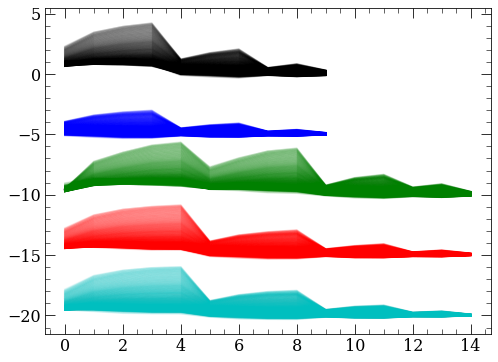

In [237]:
plt.plot(mpms_colors.T, color = 'k', alpha = 0.1);
plt.plot(ps_mpms_colors.T - 5, color = 'b', alpha = 0.1)
plt.plot(sm_mpms_colors.T - 10, color = 'g', alpha = 0.1)
plt.plot(lsst_mpms_colors.T - 15, color = 'r', alpha = 0.1);
plt.plot(decam_mpms_colors.T - 20, color = 'c', alpha = 0.1);

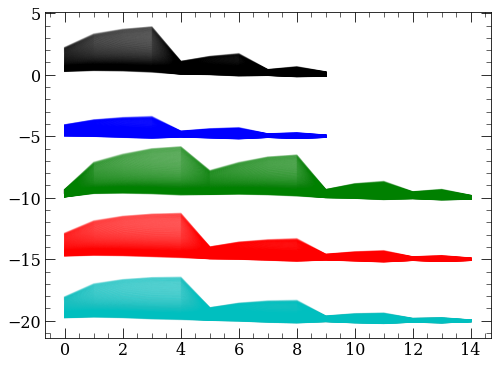

In [341]:
plt.plot(wd_colors.T, color = 'k', alpha = 0.1);
plt.plot(ps_wd_colors.T - 5, color = 'b', alpha = 0.1)
plt.plot(sm_wd_colors.T - 10, color = 'g', alpha = 0.1)
plt.plot(lsst_wd_colors.T - 15, color = 'r', alpha = 0.1);
plt.plot(decam_wd_colors.T - 20, color = 'c', alpha = 0.1);

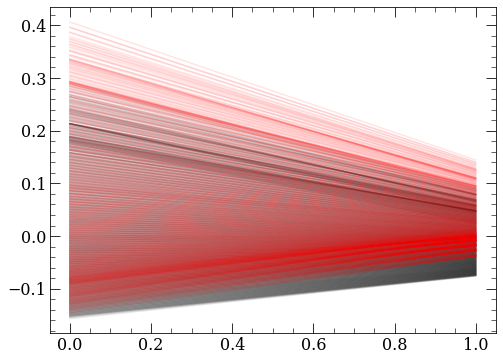

In [359]:
plt.plot(ps_wd_colors[:, -2:].T, color = 'k', alpha = 0.1);

plt.plot(ps_mpms_colors[:, -2:].T, color = 'r', alpha = 0.1);

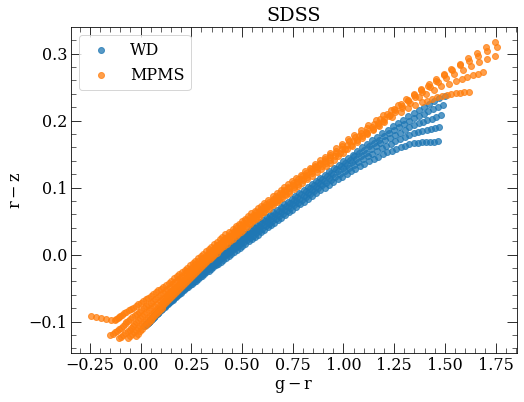

In [374]:
plt.scatter(wd_colors[:, 5], wd_colors[:, 9], label = 'WD', alpha = 0.75)

plt.scatter(mpms_colors[:, 5], mpms_colors[:, 9], label = 'MPMS', alpha = 0.75)

plt.ylabel('$r-z$')
plt.xlabel('$g-r$')
plt.title('SDSS')
plt.legend()

Text(0.5, 0, 'Effective Temperature (K)')

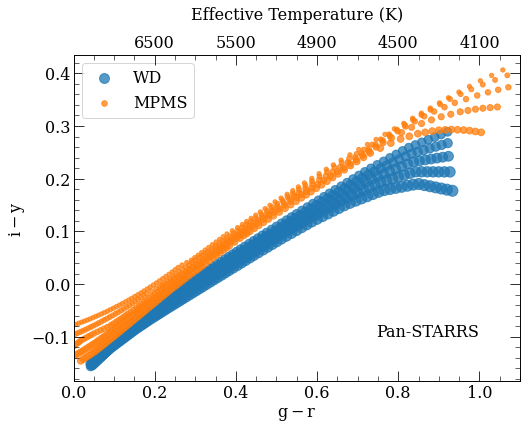

In [389]:
plt.scatter(ps_wd_colors[:, 0], ps_wd_colors[:, 8], label = 'WD', alpha = 0.75,
            s = 1.5*(wd_param_grid[:, 1])**2)

plt.scatter(ps_mpms_colors[:, 0], ps_mpms_colors[:, 8], label = 'MPMS', alpha = 0.75,
            s = 1.5*(mpms_param_grid[:, 1])**2)

plt.legend()
ticklocs = [0.2, 0.4, 0.6, 0.8, 1]

plt.ylabel('$i-y$')
plt.xlabel('$g-r$')
plt.text(1, -0.1, 'Pan-STARRS', ha = 'right')
plt.xlim(0, 1.1)

ax = plt.gca()
axtop = ax.twiny()

tickfunc = interp1d(ps_mpms_colors[:, 0], wd_param_grid[:, 0])
axtop.set_xlim(ax.get_xlim())
axtop.set_xticks(ticklocs)
axtop.set_xticklabels(np.round(tickfunc(ticklocs), -2).astype(int))
axtop.set_xlabel('Effective Temperature (K)' , labelpad = 15)

In [382]:
wd_param_grid[:, 1]

array([7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 ,
       8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  ,
       7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125,
       9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375,
       8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    ,
       7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 ,
       8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  ,
       7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125,
       9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375,
       8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    ,
       7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 ,
       8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  ,
       7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375, 8.025 , 8.5125,
       9.    , 7.05  , 7.5375, 8.025 , 8.5125, 9.    , 7.05  , 7.5375,
      

In [280]:
len(ps_wd_colors)

500

In [282]:
wd_colors.shape

(500, 10)

In [283]:
balmer_features = np.loadtxt('tables/balmer_features.txt')

## LR

In [316]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [317]:
X = np.vstack((wd_colors, mpms_colors))

t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [319]:
lr = LogisticRegression(penalty = 'l2', solver = 'saga', max_iter = 10000, tol = 1e-8)

In [320]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, solver='saga', tol=1e-08)

In [321]:
lr.score(X_test, y_test)

0.88

In [322]:
pickle.dump(lr, open('LR/phot_lr.p', 'wb'))

## griz only

In [323]:
X = np.vstack((wd_colors, mpms_colors))
X = X[:, 4:]
t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [325]:
lr = LogisticRegression(penalty = 'l2', max_iter = 10000, tol = 1e-8)

In [326]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, tol=1e-08)

In [327]:
lr.score(X_test, y_test)

0.74

In [328]:
pickle.dump(lr, open('LR/phot_lr_griz.p', 'wb'))

## Combined with Balmer

In [329]:
X = np.vstack((wd_colors, mpms_colors))
X = np.hstack((X, balmer_features))
t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [331]:
lr = LogisticRegression(penalty = 'l2', max_iter = 10000, tol = 1e-8)

In [332]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, tol=1e-08)

In [333]:
lr.score(X_test, y_test)

0.98

In [334]:
pickle.dump(lr, open('LR/combined.p', 'wb'))

## Write Training Grid

In [335]:
features = ['Su', 'Sg', 'Sr', 'Si', 'Sz', 
            'Pg', 'Pr', 'Pi', 'Pz', 'Py',
            'SMu', 'SMv', 'SMg', 'SMr', 'SMi', 'SMz',
            'VRu', 'VRg', 'VRr', 'VRi', 'VRz', 'VRy',
            'DEu', 'DEg', 'DEr', 'DEi', 'DEz', 'DEy',
                                                'a_fwhm', 'a_height',
                                               'b_fwhm', 'b_height',
                                               'g_fwhm', 'g_height',
                                               'd_fwhm', 'd_height']

In [336]:
X_S = np.vstack((wd_seds, mpms_seds))
X_P = np.vstack((ps_wd_seds, ps_mpms_seds))
X_SM = np.vstack((sm_wd_seds, sm_mpms_seds))
X_VR = np.vstack((lsst_wd_seds, lsst_mpms_seds))
X_DE = np.vstack((decam_wd_seds, decam_mpms_seds))
X = np.hstack((X_S, X_P, X_SM, X_VR, X_DE, balmer_features))
t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [337]:
df = pd.DataFrame(X, columns = features)

In [338]:
df['is_mpms'] = t.astype(int)

In [339]:
df.to_csv('../training_grid.csv')

In [340]:
df

,Su,Sg,Sr,Si,Sz,Pg,Pr,Pi,Pz,Py,...,DEy,a_fwhm,a_height,b_fwhm,b_height,g_fwhm,g_height,d_fwhm,d_height,is_mpms
0,-30.864439,-33.002723,-34.076125,-34.501483,-34.738759,-33.169485,-34.091032,-34.511633,-34.708754,-34.800473,...,-34.816304,68.722023,5.250495e-17,135.574791,2.451445e-12,121.246730,0.001301,87.140825,0.001974,0
1,-30.891696,-33.065917,-34.142090,-34.554854,-34.778239,-33.234556,-34.156450,-34.564553,-34.752230,-34.831893,...,-34.842698,73.274545,5.851328e-16,135.682068,4.201962e-13,123.059446,0.001614,86.696015,0.002134,0
2,-30.924997,-33.126218,-34.206874,-34.606331,-34.814156,-33.296888,-34.220678,-34.615528,-34.792937,-34.858002,...,-34.862444,80.706483,7.536449e-11,135.558573,2.316845e-12,124.456404,0.001982,86.805774,0.002315,0
3,-30.958123,-33.182364,-34.269507,-34.654654,-34.844567,-33.355205,-34.282748,-34.663275,-34.829249,-34.876114,...,-34.872343,72.343699,1.074979e-15,135.226837,2.775173e-11,125.179149,0.002353,87.214003,0.002484,0
4,-30.992626,-33.234090,-34.330237,-34.699093,-34.867916,-33.409336,-34.342867,-34.707025,-34.859797,-34.884101,...,-34.870011,54.099272,5.775127e-16,146.118797,3.799791e-11,125.867474,0.002751,86.954981,0.002610,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-38.761924,-39.832565,-39.715112,-39.587246,-39.495870,-39.831393,-39.714482,-39.582665,-39.490885,-39.504655,...,-39.496171,17.520920,4.329023e-01,20.277590,5.581122e-01,17.469963,0.634343,16.474627,0.671706,1
996,-38.773499,-39.776109,-39.730465,-39.627303,-39.507419,-39.786004,-39.730184,-39.623185,-39.508210,-39.508191,...,-39.503175,22.019697,4.074264e-01,23.038279,5.302912e-01,19.359349,0.599122,17.658142,0.633622,1
997,-38.791557,-39.734579,-39.718810,-39.629885,-39.504783,-39.748442,-39.718745,-39.626061,-39.509113,-39.496987,...,-39.493023,23.943804,3.957183e-01,23.970393,5.137372e-01,19.980036,0.579995,18.028516,0.613903,1
998,-38.822672,-39.691468,-39.702880,-39.627904,-39.502967,-39.708599,-39.703001,-39.624394,-39.510732,-39.485286,...,-39.481734,25.436618,3.863118e-01,24.030598,4.990293e-01,19.892350,0.562338,17.828012,0.595515,1
